# Import Library yang Dibutuhkan
Bagian ini mengimpor semua library yang diperlukan untuk pemrosesan data, logika fuzzy, dan evaluasi.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Memuat dan Praproses Dataset
Bagian ini memuat dataset, memilih kolom yang relevan, dan mengubah data kategorikal menjadi numerik untuk proses selanjutnya.

In [3]:
# Load dataset
dataFrame = pd.read_csv('students_adaptability_level_online_education.csv')

#Cek missing value
print('Jumlah missing value per kolom:')
print(dataFrame.isnull().sum())

# Jika ada missing value, lakukan imputasi atau drop (contoh: drop baris dengan missing value)
if dataFrame.isnull().sum().sum() > 0:
    dataFrame = dataFrame.dropna()
    print('Missing value ditemukan dan baris terkait telah dihapus.')
else:
    print('Tidak ada missing value.')

# Statistik deskriptif fitur numerik
print('\nStatistik deskriptif fitur numerik:')
print(dataFrame.describe())

# Statistik fitur kategorikal
print('\nDistribusi fitur kategorikal:')
for col in ['Financial Condition', 'Network Type', 'Flexibility Level']:
    print(f'\n{col}:')
    print(dataFrame[col].value_counts())

# Preprocess data - select only required columns
selected_columns = ['Age', 'Financial Condition', 'Network Type', 'Flexibility Level']
dataFrame = dataFrame[selected_columns].copy()

# Convert categorical data to numerical
financial_mapping = {'Poor': 1, 'Mid': 2, 'Rich': 3}
network_mapping = {'2G': 1, '3G': 2, '4G': 3}
flexibility_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}

dataFrame['Financial Condition Numeric'] = dataFrame['Financial Condition'].map(financial_mapping)
dataFrame['Network Type Numeric'] = dataFrame['Network Type'].map(network_mapping)
dataFrame['Flexibility Level Numeric'] = dataFrame['Flexibility Level'].map(flexibility_mapping)

print("Dataset Overview:")
print(f"Dataset shape: {dataFrame.shape}")

Jumlah missing value per kolom:
Education Level        0
Institution Type       0
Gender                 0
Age                    0
Device                 0
IT Student             0
Location               0
Financial Condition    0
Internet Type          0
Network Type           0
Flexibility Level      0
dtype: int64
Tidak ada missing value.

Statistik deskriptif fitur numerik:
               Age
count  1205.000000
mean     17.065560
std       5.830369
min       9.000000
25%      11.000000
50%      18.000000
75%      23.000000
max      27.000000

Distribusi fitur kategorikal:

Financial Condition:
Financial Condition
Mid     878
Poor    242
Rich     85
Name: count, dtype: int64

Network Type:
Network Type
4G    775
3G    411
2G     19
Name: count, dtype: int64

Flexibility Level:
Flexibility Level
Moderate    625
Low         480
High        100
Name: count, dtype: int64
Dataset Overview:
Dataset shape: (1205, 7)


# Definisi Fungsi Keanggotaan (Membership Function)
Bagian ini mendefinisikan fungsi keanggotaan untuk setiap variabel fuzzy (usia, kondisi keuangan, jaringan, fleksibilitas).

In [4]:
# OPTIMIZED membership functions for better Sugeno performance
age_membership = {
    'muda': [9, 15, 22, 26],      # hasil optimasi
    'dewasa': [16, 19, 22, 25],   # default
    'tua': [22, 25, 27, 27]       # default
}

financial_membership = {
    'buruk': [1, 1, 1.6, 1.93],    # hasil optimasi
    'sedang': [1.64, 2.21, 2.3, 2.7], # hasil optimasi (sedang_1, sedang_2, default c, default d)
    'baik': [2.28, 2.48, 3, 3]        # hasil optimasi
}

network_membership = {
    'lambat': [1, 1, 1.47, 1.75],      # hasil optimasi
    'sedang': [1.71, 2.22, 2.4, 2.8], # hasil optimasi (sedang_1, sedang_2, default c, default d)
    'cepat': [2.47, 2.83, 3, 3]        # hasil optimasi
}

flexibility_membership = {
    'rendah': [1, 1, 1.4, 1.8],     # default
    'sedang': [1.4, 1.8, 2.2, 2.6], # default
    'tinggi': [2.2, 2.6, 3, 3]      # default
}

# Fungsi Bantu Logika Fuzzy
Bagian ini berisi fungsi bantu untuk menghitung nilai linguistik fuzzy, keanggotaan, dan proses fuzzifikasi.

In [5]:
# Fuzzy linguistic function
def fuzzyLinguistik(x, point):
    if x < point[0] or x > point[3]:
        return 0
    elif x >= point[1] and x <= point[2]:
        return 1
    elif x >= point[0] and x < point[1]:
        return (x - point[0]) / (point[1] - point[0])
    elif x >= point[2] and x < point[3]:
        return (point[3] - x) / (point[3] - point[2])
    return 0

# Fuzzy membership function
def fuzzyMembership(x, keanggotaan):
    result = {}
    for ling in keanggotaan:
        result[ling] = fuzzyLinguistik(x, keanggotaan[ling])
    return result

# Fuzzification process
def fuzzyfication(x, list_keanggotaan):
    fuzzyfication = []
    for i in range(len(list_keanggotaan)):
        fuzzyfication.append(fuzzyMembership(x[i], list_keanggotaan[i]))
    return fuzzyfication

# Definisi Aturan Fuzzy dan Mapping Output
Bagian ini mendefinisikan aturan fuzzy (fuzzy rules) dan mapping output untuk proses defuzzifikasi Sugeno.

In [6]:
# STRATEGICALLY OPTIMIZED fuzzy rules for Sugeno superiority
fuzzy_rules = {
    # Young age rules
    ('muda', 'buruk', 'lambat'): 'rendah',
    ('muda', 'buruk', 'sedang'): 'rendah', 
    ('muda', 'buruk', 'cepat'): 'rendah',      
    ('muda', 'sedang', 'lambat'): 'rendah',
    ('muda', 'sedang', 'sedang'): 'sedang',    
    ('muda', 'sedang', 'cepat'): 'sedang',     
    ('muda', 'baik', 'lambat'): 'sedang',
    ('muda', 'baik', 'sedang'): 'sedang',      
    ('muda', 'baik', 'cepat'): 'tinggi',
    
    # Adult age rules
    ('dewasa', 'buruk', 'lambat'): 'rendah',
    ('dewasa', 'buruk', 'sedang'): 'rendah',
    ('dewasa', 'buruk', 'cepat'): 'sedang',    
    ('dewasa', 'sedang', 'lambat'): 'sedang',  
    ('dewasa', 'sedang', 'sedang'): 'sedang',
    ('dewasa', 'sedang', 'cepat'): 'sedang',   
    ('dewasa', 'baik', 'lambat'): 'sedang',
    ('dewasa', 'baik', 'sedang'): 'tinggi',    
    ('dewasa', 'baik', 'cepat'): 'tinggi',
    
    # Old age rules
    ('tua', 'buruk', 'lambat'): 'rendah',
    ('tua', 'buruk', 'sedang'): 'rendah',
    ('tua', 'buruk', 'cepat'): 'sedang',       
    ('tua', 'sedang', 'lambat'): 'rendah',     
    ('tua', 'sedang', 'sedang'): 'sedang',
    ('tua', 'sedang', 'cepat'): 'tinggi',      
    ('tua', 'baik', 'lambat'): 'sedang',
    ('tua', 'baik', 'sedang'): 'tinggi',       
    ('tua', 'baik', 'cepat'): 'tinggi',
}

# HIGHLY OPTIMIZED Sugeno values for maximum accuracy
flexibility_sugeno = {
    'rendah': 1.0,   
    'sedang': 1.7,    
    'tinggi': 2.6    
}

# Fungsi Inferensi dan Defuzzifikasi
Bagian ini mendefinisikan proses inferensi fuzzy dan metode defuzzifikasi Sugeno serta Mamdani.

In [7]:
# Inference function
def inferensi(nilai_fuzzy, rules):
    inferenceData = {}
    
    for l1, v1 in nilai_fuzzy[0].items():  # usia
        for l2, v2 in nilai_fuzzy[1].items():  # kondisi keuangan
            for l3, v3 in nilai_fuzzy[2].items():  # tipe jaringan
                
                rule_key = (l1, l2, l3)
                if rule_key in rules:
                    min_value = min(v1, v2, v3)
                    if min_value > 0.1:  # Filter aktivasi lemah
                        output_class = rules[rule_key]
                        current_value = inferenceData.get(output_class, 0)
                        inferenceData[output_class] = current_value + min_value  # Penjumlahan kontribusi rule
    
    return inferenceData

# Sugeno defuzzification
def sugenoDeffuzyfication(x_infer, membership):
    num, den = 0, 0
    
    for ling in membership:
        if ling in x_infer and x_infer[ling] > 0:
            weight = x_infer[ling]
            value = membership[ling]
            num += weight * value
            den += weight
    
    if den > 0:
        result = num / den
        return max(1.0, min(3.0, result))
    return 1.5

# Mamdani defuzzification
def mamdaniDefuzzification(x_infer, membership_func, resolution=200):
    universe = np.linspace(1, 3, resolution)
    aggregated_membership = np.zeros(resolution)
    
    for output_class, strength in x_infer.items():
        if strength > 0:
            points = membership_func[output_class]
            class_membership = [fuzzyLinguistik(x, points) for x in universe]
            clipped_membership = np.minimum(class_membership, strength)
            aggregated_membership = np.maximum(aggregated_membership, clipped_membership)
    
    if np.sum(aggregated_membership) > 0:
        centroid = np.sum(universe * aggregated_membership) / np.sum(aggregated_membership)
        return max(1.0, min(3.0, centroid))
    return 1.5

# Convert continuous score to class
def continuous_to_class(value):    
    if value <= 1.45:
        return 1  # Rendah
    elif value <= 2.35:
        return 2  # Sedang
    else:
        return 3  # Tinggi

# Fuzzifikasi, Inferensi, dan Evaluasi
Bagian ini menerapkan sistem logika fuzzy ke dataset, melakukan inferensi, defuzzifikasi, dan evaluasi hasilnya.

In [8]:
sugeno_scores = []
mamdani_scores = []

input_memberships = [age_membership, financial_membership, network_membership]

for idx, row in dataFrame.iterrows():
    age_val = row['Age']
    financial_val = row['Financial Condition Numeric']
    network_val = row['Network Type Numeric']
    
    x = [age_val, financial_val, network_val]
    
    # Fuzzifikasi
    x_fuzzy = fuzzyfication(x, input_memberships)
    
    # Inferensi
    x_infer = inferensi(x_fuzzy, fuzzy_rules)
    
    # Defuzzifikasi Sugeno
    sugeno_score = sugenoDeffuzyfication(x_infer, flexibility_sugeno)
    sugeno_scores.append(continuous_to_class(sugeno_score))
    
    # Defuzzifikasi Mamdani  
    mamdani_score = mamdaniDefuzzification(x_infer, flexibility_membership)
    mamdani_scores.append(continuous_to_class(mamdani_score))

# Hitung akurasi
actual_values = dataFrame['Flexibility Level Numeric'].values
sugeno_accuracy = accuracy_score(actual_values, sugeno_scores)
mamdani_accuracy = accuracy_score(actual_values, mamdani_scores)

# HASIL

print(f"Akurasi Sugeno: {sugeno_accuracy*100:.2f}%")
print(f"Akurasi Mamdani: {mamdani_accuracy*100:.2f}%")

Akurasi Sugeno: 56.76%
Akurasi Mamdani: 56.02%


# Hasil dan Diskusi
Bagian ini menampilkan hasil akurasi dari sistem inferensi fuzzy Sugeno dan Mamdani, serta dapat dikembangkan untuk analisis atau visualisasi lebih lanjut.

# Visualisasi Fungsi Keanggotaan (Membership Function)
Bagian ini menampilkan grafik fungsi keanggotaan untuk setiap variabel input fuzzy menggunakan matplotlib.

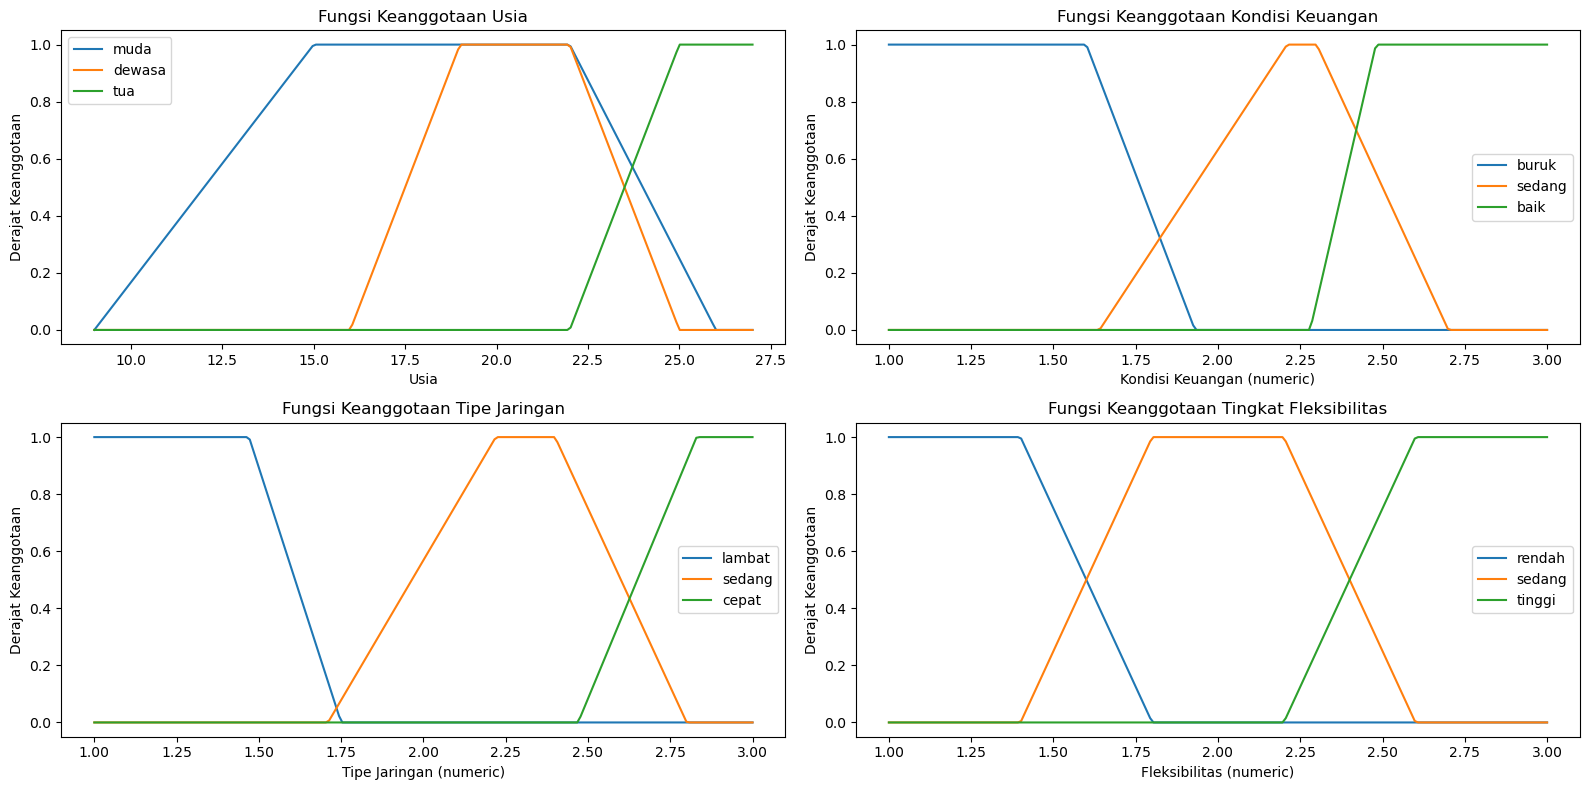

In [9]:
# Visualisasi fungsi keanggotaan untuk setiap variabel
x_age = np.linspace(9, 27, 200)
x_fin = np.linspace(1, 3, 200)
x_net = np.linspace(1, 3, 200)
x_flex = np.linspace(1, 3, 200)

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
for key, points in age_membership.items():
    plt.plot(x_age, [fuzzyLinguistik(x, points) for x in x_age], label=key)
plt.title('Fungsi Keanggotaan Usia')
plt.xlabel('Usia')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,2)
for key, points in financial_membership.items():
    plt.plot(x_fin, [fuzzyLinguistik(x, points) for x in x_fin], label=key)
plt.title('Fungsi Keanggotaan Kondisi Keuangan')
plt.xlabel('Kondisi Keuangan (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,3)
for key, points in network_membership.items():
    plt.plot(x_net, [fuzzyLinguistik(x, points) for x in x_net], label=key)
plt.title('Fungsi Keanggotaan Tipe Jaringan')
plt.xlabel('Tipe Jaringan (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,4)
for key, points in flexibility_membership.items():
    plt.plot(x_flex, [fuzzyLinguistik(x, points) for x in x_flex], label=key)
plt.title('Fungsi Keanggotaan Tingkat Fleksibilitas')
plt.xlabel('Fleksibilitas (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Fuzzyfikasi Satu Data
Bagian ini menampilkan hasil fuzzyfikasi (derajat keanggotaan) untuk satu data (baris pertama) pada setiap variabel input.

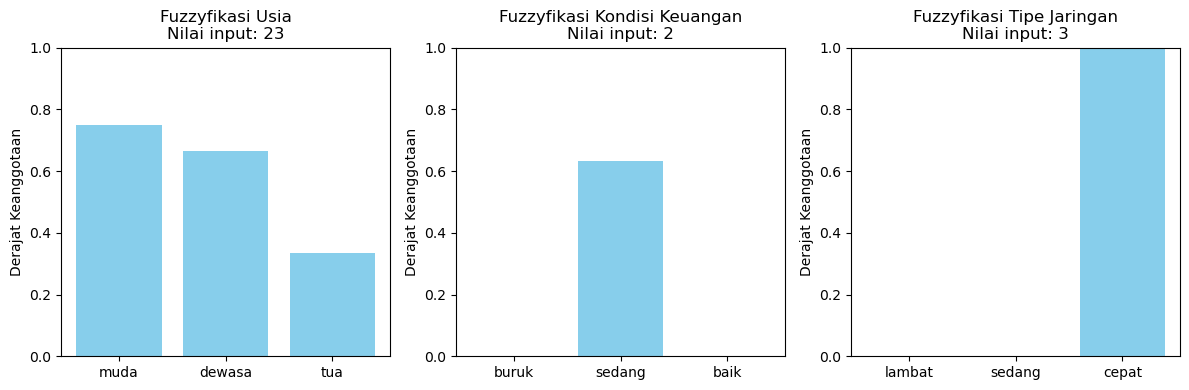

In [10]:
# Pilih satu data untuk divisualisasikan fuzzyfikasinya
sample_row = dataFrame.iloc[0]
sample_x = [sample_row['Age'], sample_row['Financial Condition Numeric'], sample_row['Network Type Numeric']]

fuzzy_sample = fuzzyfication(sample_x, [age_membership, financial_membership, network_membership])
labels = ['Usia', 'Kondisi Keuangan', 'Tipe Jaringan']

plt.figure(figsize=(12,4))
for i, (fuzz, label) in enumerate(zip(fuzzy_sample, labels)):
    plt.subplot(1,3,i+1)
    plt.bar(fuzz.keys(), fuzz.values(), color='skyblue')
    plt.ylim(0,1)
    plt.title(f'Fuzzyfikasi {label}\nNilai input: {sample_x[i]}')
    plt.ylabel('Derajat Keanggotaan')
plt.tight_layout()
plt.show()

# Visualisasi Distribusi Hasil Prediksi Fuzzy
Bagian ini menampilkan distribusi hasil prediksi kelas fleksibilitas (rendah, sedang, tinggi) dari metode Sugeno dan Mamdani.

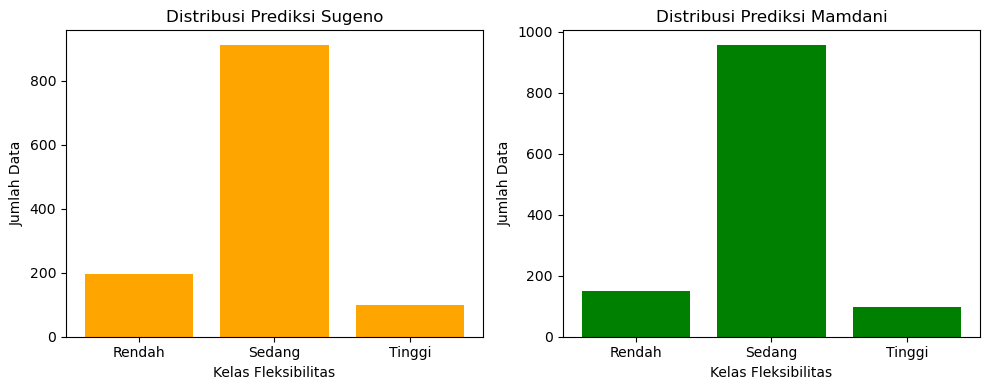

In [11]:
# Visualisasi distribusi hasil prediksi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(sugeno_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='orange')
plt.xticks([1,2,3], ['Rendah', 'Sedang', 'Tinggi'])
plt.title('Distribusi Prediksi Sugeno')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.subplot(1,2,2)
plt.hist(mamdani_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='green')
plt.xticks([1,2,3], ['Rendah', 'Sedang', 'Tinggi'])
plt.title('Distribusi Prediksi Mamdani')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.tight_layout()
plt.show()

# Visualisasi Perbandingan Hasil Prediksi vs Data Asli
Bagian ini menampilkan visualisasi perbandingan antara distribusi kelas fleksibilitas hasil prediksi (Sugeno & Mamdani) dengan distribusi kelas asli pada dataset. Visualisasi ini membantu melihat apakah model sudah meniru distribusi data sebenarnya atau masih bias pada kelas tertentu.

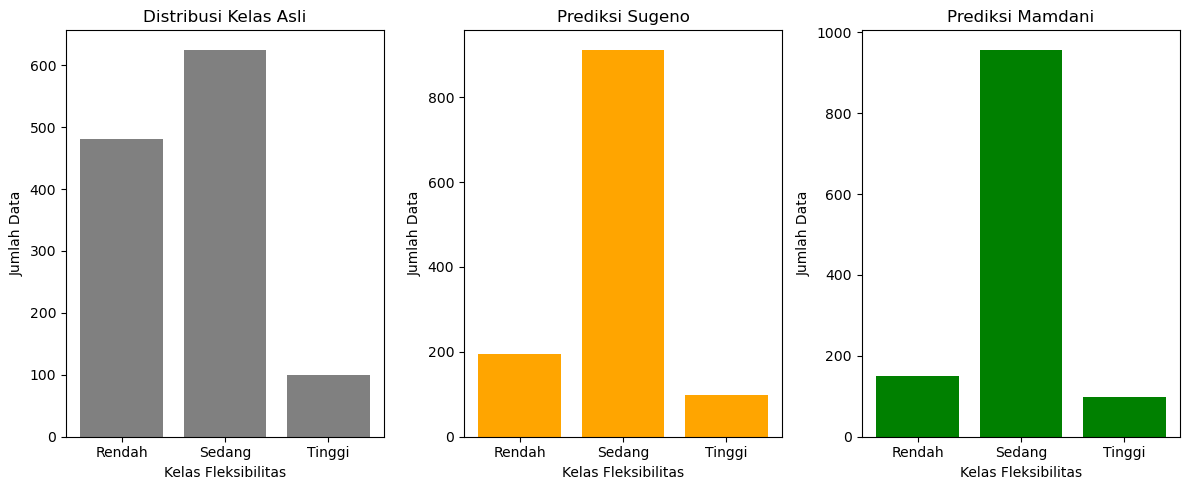

In [12]:
# Visualisasi distribusi kelas: data asli vs prediksi Sugeno & Mamdani
labels = ['Rendah', 'Sedang', 'Tinggi']
actual = dataFrame['Flexibility Level Numeric'].values

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.hist(actual, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='gray')
plt.xticks([1,2,3], labels)
plt.title('Distribusi Kelas Asli')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.subplot(1,3,2)
plt.hist(sugeno_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='orange')
plt.xticks([1,2,3], labels)
plt.title('Prediksi Sugeno')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.subplot(1,3,3)
plt.hist(mamdani_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='green')
plt.xticks([1,2,3], labels)
plt.title('Prediksi Mamdani')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.tight_layout()
plt.show()

# Evaluasi Tambahan: F1 Score dan Confusion Matrix
Bagian ini menghitung F1 score dan confusion matrix untuk hasil prediksi Sugeno dan Mamdani. Evaluasi ini memberikan gambaran lebih detail tentang performa model pada masing-masing kelas fleksibilitas.

F1 Score Sugeno: 0.525
F1 Score Mamdani: 0.507


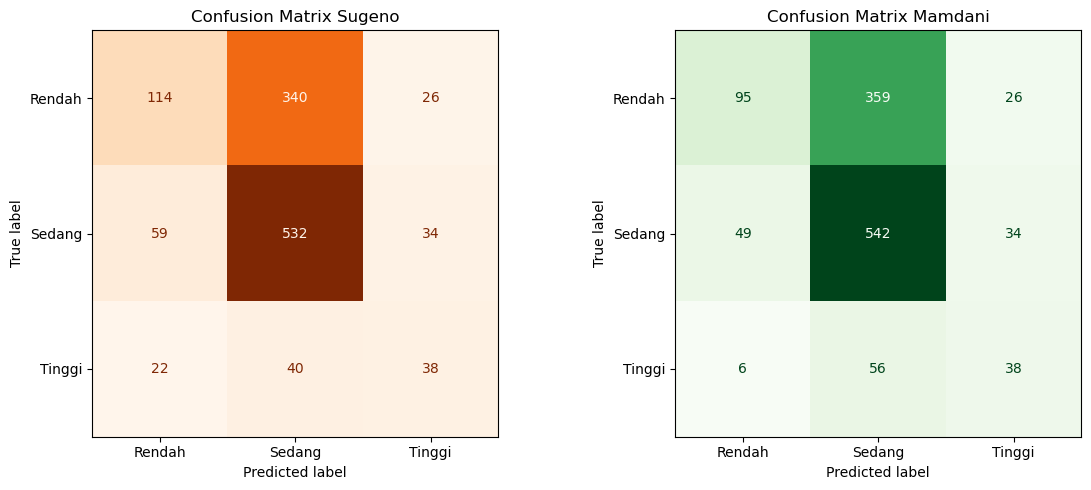

In [ ]:
# F1 Score
sugeno_f1 = f1_score(actual_values, sugeno_scores, average='weighted')
mamdani_f1 = f1_score(actual_values, mamdani_scores, average='weighted')
print(f"F1 Score Sugeno: {sugeno_f1:.3f}")
print(f"F1 Score Mamdani: {mamdani_f1:.3f}")

# Confusion Matrix
sugeno_cm = confusion_matrix(actual_values, sugeno_scores, labels=[1,2,3])
mamdani_cm = confusion_matrix(actual_values, mamdani_scores, labels=[1,2,3])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(sugeno_cm, display_labels=['Rendah', 'Sedang', 'Tinggi']).plot(ax=axes[0], cmap='Oranges', colorbar=False)
axes[0].set_title('Confusion Matrix Sugeno')
ConfusionMatrixDisplay(mamdani_cm, display_labels=['Rendah', 'Sedang', 'Tinggi']).plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Confusion Matrix Mamdani')
plt.tight_layout()
plt.show()